In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
# !ros2 topic hz /camera_ids/image_color -w 20

1726135978.693845 [42]       ros2: config: //CycloneDDS/Domain/General: 'NetworkInterfaceAddress': deprecated element (/root/.ros/cyclonedds.xml line 5)
average rate: 9.895
	min: 0.076s max: 0.133s std dev: 0.01473s window: 11
average rate: 9.952
	min: 0.076s max: 0.133s std dev: 0.01144s window: 20
average rate: 9.950
	min: 0.092s max: 0.117s std dev: 0.00537s window: 20
average rate: 10.049
	min: 0.064s max: 0.133s std dev: 0.01284s window: 20
average rate: 10.145
	min: 0.064s max: 0.133s std dev: 0.01235s window: 20
average rate: 9.983
	min: 0.090s max: 0.110s std dev: 0.00475s window: 20
average rate: 10.032
	min: 0.074s max: 0.118s std dev: 0.00781s window: 20
average rate: 10.085
	min: 0.074s max: 0.108s std dev: 0.00719s window: 20
^C


In [3]:
import IPython.display as display
from pathlib import Path

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from cv_bridge import CvBridge
from message_filters import ApproximateTimeSynchronizer, Cache, Subscriber as SubscriberFilter
from rclpy.callback_groups import MutuallyExclusiveCallbackGroup, ReentrantCallbackGroup
from rclpy.duration import Duration
from rclpy.time import Time
from rclpy.node import Node
from rclpy.qos import HistoryPolicy, ReliabilityPolicy, QoSProfile
from rcl_interfaces.msg import FloatingPointRange, IntegerRange, ParameterDescriptor, ParameterType
from sensor_msgs.msg import CameraInfo, Image, PointCloud2, PointField
from std_msgs.msg import Header
from tf2_ros import TransformBroadcaster
from tf2_ros.buffer import Buffer
from tf2_ros.transform_listener import TransformListener

import nimbro_utils.compat.point_cloud2 as point_cloud2
from nimbro_utils.parameter_handler import ParameterHandler
from nimbro_utils.tf_oracle import TFOracle

import time

from nimbro_depthanything.metric_depth.depth_anything_v2.dpt import DepthAnythingV2


class NodeDepthAnything(Node):
    def __init__(
        self,
        topic_image="/camera_ids/image_color",
        topic_inferred_depth="/camera_ids/inferred/depth/image",
        name_encoder="small",
        name_dataset="hypersim",
        max_depth=20,
    ):
        super().__init__(node_name="depth_anything")

        self.bridge_cv = None
        self.device = None
        self.name_dataset = name_dataset
        self.name_encoder = name_encoder
        self.handler_parameters = None
        self.max_depth = max_depth
        self.profile_qos = None
        self.service_colorize_points = None
        self.service_project_dome = None
        self.subscriber_image = None
        self.topic_image = topic_image
        self.topic_inferred_depth = topic_inferred_depth

        self._init()

    def _init(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bridge_cv = CvBridge()
        self.profile_qos = QoSProfile(reliability=ReliabilityPolicy.BEST_EFFORT, history=HistoryPolicy.KEEP_LAST, depth=1)
        self.handler_parameters = ParameterHandler(self, verbose=False)

        # self._init_parameters()

        # self._init_tf_oracle()
        # self._del_publishers()

        # self._del_services()
        # self._init_services()
        # self._del_subscribers()

        model_configs = {
            "small": {"encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384]},
            "base": {"encoder": "vitb", "features": 128, "out_channels": [96, 192, 384, 768]},
            "large": {"encoder": "vitl", "features": 256, "out_channels": [256, 512, 1024, 1024]},
        }

        self.model = DepthAnythingV2(**{**model_configs[self.name_encoder], "max_depth": self.max_depth})
        name_encoder_internal = model_configs[self.name_encoder]["encoder"]
        self.model.load_state_dict(torch.load(f"checkpoints/depth_anything_v2_metric_{self.name_dataset}_{name_encoder_internal}.pth"))
        self.model.eval()
        self.model.to(self.device)

        self.i = 0

        self._init_subscribers()
        self._init_publishers()

    def _init_subscribers(self):
        self.subscriber_image = self.create_subscription(Image, self.topic_image, self.infer_depth, qos_profile=self.profile_qos, callback_group=MutuallyExclusiveCallbackGroup())

    def _init_publishers(self):
        self.publisher_image = self.create_publisher(msg_type=Image, topic=self.topic_inferred_depth, qos_profile=self.profile_qos, callback_group=ReentrantCallbackGroup())

    def publish_image(self, image, name_frame, stamp):
        header = Header(stamp=stamp, frame_id=name_frame)
        message = self.bridge_cv.cv2_to_imgmsg(image, header=header, encoding="mono16")

        self.publisher_depth.publish(message)

    def visualize_depth_image(self, image_depth, image_rgb, time_needed):
        din_a4 = np.array([210, 297]) / 25.4
        din_a4_landscape = din_a4[::-1]
        fig = plt.figure(figsize=din_a4_landscape)

        def visualize_image(image):
            ax = plt.gca()
            ax.set_axis_off()
            ax.imshow(image, cmap="turbo", vmin=0)

        fig.add_subplot(1, 2, 1)
        visualize_image(image_rgb)

        fig.add_subplot(1, 2, 2)
        visualize_image(image_depth)

        plt.tight_layout()
        plt.title(f"Inference time: {time_needed:.4f}")
        # plt.savefig(Path(".") / "gif" / f"image_{self.i}")
        # self.i += 1
        plt.show()

    def infer_depth(self, message_image):
        image = self.bridge_cv.imgmsg_to_cv2(message_image, desired_encoding="passthrough")
        # image = torch.as_tensor(image, dtype=torch.float16, device=self.device)

        s = time.time()
        image_depth = self.model.infer_image(image)  # HxW depth map in meters in numpy
        e = time.time()

        self.get_logger().info(f"Inference time: {e-s}")

        self.get_logger().info(f"Mean depth: {image_depth.mean()}")
        self.get_logger().info(f"Shape: {image_depth.shape}")

        # self.publish_image(image_depth, name_frame=message_image.header.frame_id, stamp=message_image.header.stamp)

        display.clear_output(wait=True)
        time_needed = e - s
        self.visualize_depth_image(image_depth, image, time_needed)

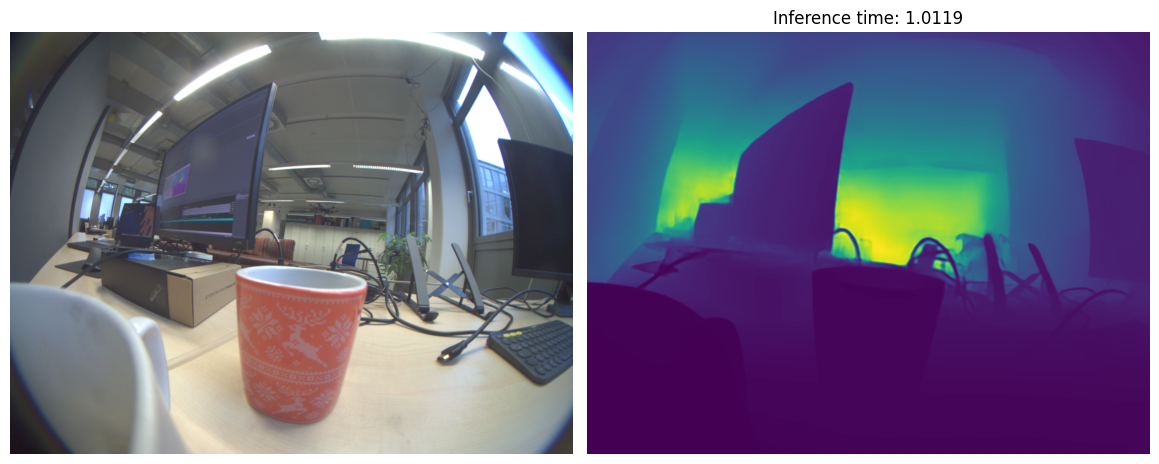

: 

: 

: 

In [7]:
import nimbro_utils.node as utils_node
import rclpy

try:
    rclpy.shutdown()
except:
    pass

utils_node.start_and_spin_node(NodeDepthAnything)

## Export ONNX

In [4]:
import nimbro_depthanything.scripts.export_model as export_model

export_model.export_model("depth_anything_v2_metric_hypersim_vits", shape_image=(3, 518, 798))

xFormers not available
xFormers not available
/root/colcon_ws/src/nimbro_depthanything/nimbro_depthanything/models/dinov2_layers/patch_embed.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H % patch_H == 0, f"Input image height {H} is not a multiple of patch height {patch_H}"
/root/colcon_ws/src/nimbro_depthanything/nimbro_depthanything/models/dinov2_layers/patch_embed.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert W % patch_W == 0, f"Input image width {W} is not a multiple of patch width: {patch_W}"
/root/colcon_ws/src/nimbro_

Model exported to /root/colcon_ws/src/nimbro_depthanything/onnx/depth_anything_v2_metric_hypersim_vits.onnx


## Export engine

In [ ]:
import nimbro_depthanything.scripts.export_engine as export_engine

export_engine.export_engine("depth_anything_v2_metric_hypersim_vits")

In [5]:
import tensorrt as trt

logger = trt.Logger(trt.Logger.INFO)
builder = trt.Builder(logger)

network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, logger)

path_onnx = Path(".") / "onnx" / "depth_anything_v2_metric_hypersim_vits.onnx"
success = parser.parse_from_file(str(path_onnx))
for idx in range(parser.num_errors):
    print(parser.get_error(idx))

if not success:
    pass # Error handling code here

config_builder = builder.create_builder_config()

if builder.platform_has_fast_fp16:
    config_builder.set_flag(trt.BuilderFlag.FP16)

# TODO: Limit memory so other things can also run?
# config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 20) # 1 MiB

engine_serialized = builder.build_serialized_network(network, config_builder)
path_engine = Path(".") / "engines" / "depth_anything_v2_metric_hypersim_vits.engine"
with open(path_engine, "wb") as file_engine:
    file_engine.write(engine_serialized)

[09/12/2024-17:58:09] [TRT] [I] [MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 736, GPU 12639 (MiB)
[09/12/2024-17:58:10] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +2235, GPU +426, now: CPU 3126, GPU 13065 (MiB)
[09/12/2024-17:58:10] [TRT] [I] ----------------------------------------------------------------
[09/12/2024-17:58:10] [TRT] [I] Input filename:   onnx/depth_anything_v2_metric_hypersim_vits.onnx
[09/12/2024-17:58:10] [TRT] [I] ONNX IR version:  0.0.8
[09/12/2024-17:58:10] [TRT] [I] Opset version:    17
[09/12/2024-17:58:10] [TRT] [I] Producer name:    pytorch
[09/12/2024-17:58:10] [TRT] [I] Producer version: 2.3.0
[09/12/2024-17:58:10] [TRT] [I] Domain:           
[09/12/2024-17:58:10] [TRT] [I] Model version:    0
[09/12/2024-17:58:10] [TRT] [I] Doc string:       
[09/12/2024-17:58:10] [TRT] [I] ----------------------------------------------------------------
[09/12/2024-17:58:10] [TRT] [I] Local timing cache in use. Profiling results in this builder p

## Run engine

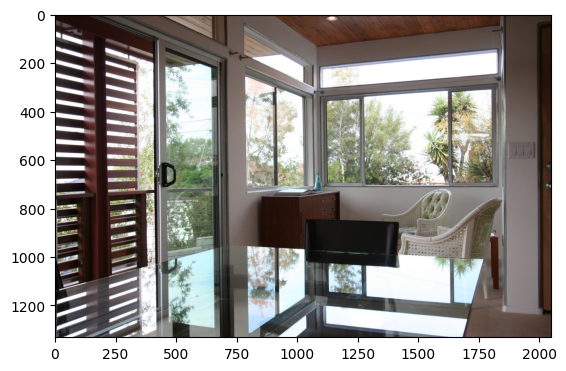

In [6]:
import matplotlib.pyplot as plt
import torchvision as tv
import torch

import nimbro_depthanything.config as config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


MODES_IMAGE = tv.io.ImageReadMode
def read_image(path, mode=MODES_IMAGE.UNCHANGED, use_exif_orientation=False):
    image = tv.io.read_image(path, mode=mode, apply_exif_orientation=use_exif_orientation)

    return image

input_image = read_image("nimbro_depthanything/other/assets/examples/demo10.jpg")
input_image = input_image.permute((1, 2, 0))

plt.imshow(input_image)

In [7]:
input_image = input_image.cpu().numpy().astype(np.uint8)
input_image.shape

(1332, 2048, 3)

In [22]:
from nimbro_depthanything.models.dpt import DepthAnythingV2

model = DepthAnythingV2(**config.MODELS["depth_anything_v2_metric_hypersim_vits"])
model = model.to(device).eval()
model.infer_image(input_image)

torch.Size([1, 3, 518, 798])


array([[10.458354 , 10.461308 , 10.464262 , ..., 10.490234 , 10.487343 ,
        10.484451 ],
       [10.4628315, 10.466467 , 10.470103 , ..., 10.495042 , 10.49298  ,
        10.490918 ],
       [10.467308 , 10.471625 , 10.475944 , ..., 10.499848 , 10.498617 ,
        10.497385 ],
       ...,
       [10.419484 , 10.419585 , 10.419687 , ..., 10.474566 , 10.47083  ,
        10.467093 ],
       [10.416397 , 10.41533  , 10.414266 , ..., 10.444223 , 10.444045 ,
        10.443867 ],
       [10.413309 , 10.411076 , 10.408843 , ..., 10.41388  , 10.417261 ,
        10.420641 ]], dtype=float32)

In [17]:
import torchvision.transforms.v2 as tv_transforms
import cv2
import nimbro_depthanything.models.util.transform as custom_transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size=518

transform = tv_transforms.Compose([
            custom_transforms.Resize(
                width=input_size,
                height=input_size,
                resize_target=False,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method='lower_bound',
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            custom_transforms.NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            custom_transforms.PrepareForNet(),
        ])
        
image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB) / 255.0
        
image = transform({'image': image})['image']
image = torch.from_numpy(image)[None, ...]

In [18]:
image.shape

torch.Size([1, 3, 518, 798])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.400788..3.0057352].


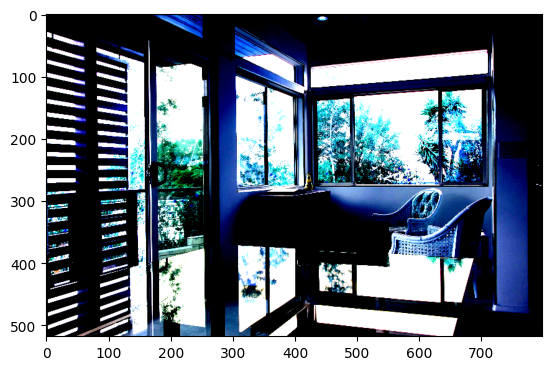

In [19]:
plt.imshow(image[0].permute((1, 2, 0)))

In [20]:
from pathlib import Path

import tensorrt as trt

path_engine = Path(".") / "engines" / "depth_anything_v2_metric_hypersim_vits.engine"

logger = trt.Logger(trt.Logger.INFO)
runtime = trt.Runtime(logger)

with open(path_engine, "rb") as file_engine:
    engine_serialized = file_engine.read()
    
engine = runtime.deserialize_cuda_engine(engine_serialized)

[09/12/2024-18:03:20] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[09/12/2024-18:03:20] [TRT] [I] Loaded engine size: 52 MiB


[09/12/2024-18:03:41] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +64, now: CPU 0, GPU 175 (MiB)
(1, 1332, 2048)


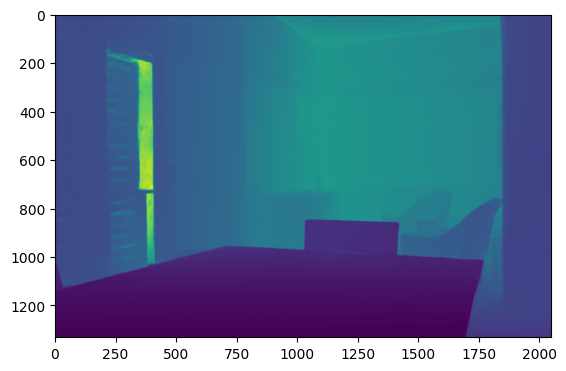

In [23]:
from torch2trt import TRTModule


# TODO: Check warning if we leave this away. Might cause overhead of stream creation
s = torch.cuda.Stream()
with torch.cuda.stream(s):
    model_trt = TRTModule(
        engine=engine,
        input_names=["input"],
        output_names=["output"],
    )
    image = image.to(device)
    output = model_trt(image)


    output = torch.nn.functional.interpolate(output[:, None], (input_image.shape[-3], input_image.shape[-2]), mode="bilinear", align_corners=True)
    depth = output[0]
    depth = depth.cpu().numpy()
    print(depth.shape)

    plt.imshow(depth.transpose((1, 2, 0)))

In [16]:
import nimbro_depthanything.config as config

from nimbro_depthanything.models import DepthAnythingV2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_weights = Path(config._PATH_DIR_WEIGHTS) / f"depth_anything_v2_metric_hypersim_vits.pth"
weights = torch.load(f"{path_weights}", map_location="cpu")

model = DepthAnythingV2(**config.MODELS["depth_anything_v2_metric_hypersim_vits"])
model.load_state_dict(weights)
model = model.to(device).eval()

In [17]:
model_scripted = torch.jit.script(model)

NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/root/colcon_ws/src/nimbro_depthanything/nimbro_depthanything/models/dinov2.py", line 323
    def forward(self, *args, is_training=False, **kwargs):
                                                 ~~~~~~~ <--- HERE
        ret = self.forward_features(*args, **kwargs)
        if is_training:


In [ ]:
stream = torch.cuda.Stream(device=device)

output = torch.ones((1, 160000), device=device)
bindings = [int(input_image.data_ptr()), int(output.data_ptr())]

with engine.create_execution_context() as context:
    context.execute_async_v2(bindings, stream_handle=stream.cuda_stream)
    stream.synchronize()

In [ ]:
depth = output.reshape()

plt.imshow(depth.permute((1, 2, 0)))

In [ ]:
with engine.create_execution_context() as context:

    context.set_tensor_address(name, ptr)

    stream = torch.cuda.Stream(device=device)
    context.execute_async_v3(bindings=[int(d_input), int(d_output)], stream_handle=stream.cuda_stream)
    stream.synchronize()


    input_shape = context.get_tensor_shape("input")
    output_shape = context.get_tensor_shape("output")
    h_input = cuda.pagelocked_empty(trt.volume(input_shape), dtype=np.float32)
    h_output = cuda.pagelocked_empty(trt.volume(output_shape), dtype=np.float32)
    d_input = cuda.mem_alloc(h_input.nbytes)
    d_output = cuda.mem_alloc(h_output.nbytes)
    stream = cuda.Stream()

    # Copy the input image to the pagelocked memory
    np.copyto(h_input, input_image.ravel())

    # Copy the input to the GPU, execute the inference, and copy the output back to the CPU
    cuda.memcpy_htod_async(d_input, h_input, stream)
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
    cuda.memcpy_dtoh_async(h_output, d_output, stream)
    stream.synchronize()
    depth = h_output

    # # Process the depth output
    # depth = np.reshape(depth, output_shape[2:])
    # depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    # depth = depth.astype(np.uint8)
    # depth = cv2.resize(depth, (orig_w, orig_h))

    # # Save the depth map
    # img_name = os.path.basename(args.img)
    # if args.grayscale:
    #     cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', depth)
    # else:
    #     colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
    #     cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', colored_depth)

In [ ]:
#!trtexec --onnx=resnet50-v1-12.onnx --shapes=data:4x3x224x224 --fp16 --noDataTransfers --useCudaGraph --useSpinWait

In [ ]:
import argparse
import os
import cv2
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
from depth_anything.util.transform import load_image


def run(args):
    # Create the output directory if it doesn't exist
    os.makedirs(args.outdir, exist_ok=True)
    input_image, (orig_h, orig_w) = load_image(args.img)

    # Create logger and load the TensorRT engine
    logger = trt.Logger(trt.Logger.WARNING)
    with open(args.engine, "rb") as f, trt.Runtime(logger) as runtime:
        engine = runtime.deserialize_cuda_engine(f.read())

    with engine.create_execution_context() as context:
        input_shape = context.get_tensor_shape("input")
        output_shape = context.get_tensor_shape("output")
        h_input = cuda.pagelocked_empty(trt.volume(input_shape), dtype=np.float32)
        h_output = cuda.pagelocked_empty(trt.volume(output_shape), dtype=np.float32)
        d_input = cuda.mem_alloc(h_input.nbytes)
        d_output = cuda.mem_alloc(h_output.nbytes)
        stream = cuda.Stream()

        # Copy the input image to the pagelocked memory
        np.copyto(h_input, input_image.ravel())

        # Copy the input to the GPU, execute the inference, and copy the output back to the CPU
        cuda.memcpy_htod_async(d_input, h_input, stream)
        context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
        cuda.memcpy_dtoh_async(h_output, d_output, stream)
        stream.synchronize()
        depth = h_output

    # Process the depth output
    depth = np.reshape(depth, output_shape[2:])
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    depth = cv2.resize(depth, (orig_w, orig_h))

    # Save the depth map
    img_name = os.path.basename(args.img)
    if args.grayscale:
        cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', depth)
    else:
        colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
        cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', colored_depth)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Run depth estimation with a TensorRT engine.")
    parser.add_argument("--img", type=str, required=True, help="Path to the input image")
    parser.add_argument("--outdir", type=str, default="./vis_depth", help="Output directory for the depth map")
    parser.add_argument("--engine", type=str, required=True, help="Path to the TensorRT engine")
    parser.add_argument("--grayscale", action="store_true", help="Save the depth map in grayscale")

    args = parser.parse_args()
    run(args)

In [ ]:
# Engine builder
        builder = trt.Builder(logger)
        config = builder.create_builder_config()
        workspace = int(self.args.workspace * (1 << 30))
        if is_trt10:
            config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, workspace)
        else:  # TensorRT versions 7, 8
            config.max_workspace_size = workspace
        flag = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
        network = builder.create_network(flag)
        half = builder.platform_has_fast_fp16 and self.args.half
        int8 = builder.platform_has_fast_int8 and self.args.int8
        # Read ONNX file
        parser = trt.OnnxParser(network, logger)
        if not parser.parse_from_file(f_onnx):
            raise RuntimeError(f"failed to load ONNX file: {f_onnx}")

        # Network inputs
        inputs = [network.get_input(i) for i in range(network.num_inputs)]
        outputs = [network.get_output(i) for i in range(network.num_outputs)]
        for inp in inputs:
            LOGGER.info(f'{prefix} input "{inp.name}" with shape{inp.shape} {inp.dtype}')
        for out in outputs:
            LOGGER.info(f'{prefix} output "{out.name}" with shape{out.shape} {out.dtype}')

        if self.args.dynamic:
            shape = self.im.shape
            if shape[0] <= 1:
                LOGGER.warning(f"{prefix} WARNING ⚠️ 'dynamic=True' model requires max batch size, i.e. 'batch=16'")
            profile = builder.create_optimization_profile()
            min_shape = (1, shape[1], 32, 32)  # minimum input shape
            max_shape = (*shape[:2], *(max(1, self.args.workspace) * d for d in shape[2:]))  # max input shape
            for inp in inputs:
                profile.set_shape(inp.name, min=min_shape, opt=shape, max=max_shape)
            config.add_optimization_profile(profile)

        LOGGER.info(f"{prefix} building {'INT8' if int8 else 'FP' + ('16' if half else '32')} engine as {f}")
        if int8:
            config.set_flag(trt.BuilderFlag.INT8)
            config.set_calibration_profile(profile)
            config.profiling_verbosity = trt.ProfilingVerbosity.DETAILED

            class EngineCalibrator(trt.IInt8Calibrator):
                def __init__(
                    self,
                    dataset,  # ultralytics.data.build.InfiniteDataLoader
                    batch: int,
                    cache: str = "",
                ) -> None:
                    trt.IInt8Calibrator.__init__(self)
                    self.dataset = dataset
                    self.data_iter = iter(dataset)
                    self.algo = trt.CalibrationAlgoType.ENTROPY_CALIBRATION_2
                    self.batch = batch
                    self.cache = Path(cache)

                def get_algorithm(self) -> trt.CalibrationAlgoType:
                    """Get the calibration algorithm to use."""
                    return self.algo

                def get_batch_size(self) -> int:
                    """Get the batch size to use for calibration."""
                    return self.batch or 1

                def get_batch(self, names) -> list:
                    """Get the next batch to use for calibration, as a list of device memory pointers."""
                    try:
                        im0s = next(self.data_iter)["img"] / 255.0
                        im0s = im0s.to("cuda") if im0s.device.type == "cpu" else im0s
                        return [int(im0s.data_ptr())]
                    except StopIteration:
                        # Return [] or None, signal to TensorRT there is no calibration data remaining
                        return None

                def read_calibration_cache(self) -> bytes:
                    """Use existing cache instead of calibrating again, otherwise, implicitly return None."""
                    if self.cache.exists() and self.cache.suffix == ".cache":
                        return self.cache.read_bytes()

                def write_calibration_cache(self, cache) -> None:
                    """Write calibration cache to disk."""
                    _ = self.cache.write_bytes(cache)

            # Load dataset w/ builder (for batching) and calibrate
            config.int8_calibrator = EngineCalibrator(
                dataset=self.get_int8_calibration_dataloader(prefix),
                batch=2 * self.args.batch,  # TensorRT INT8 calibration should use 2x batch size
                cache=str(self.file.with_suffix(".cache")),
            )

        elif half:
            config.set_flag(trt.BuilderFlag.FP16)

        # Free CUDA memory
        del self.model
        gc.collect()
        torch.cuda.empty_cache()

        # Write file
        build = builder.build_serialized_network if is_trt10 else builder.build_engine
        with build(network, config) as engine, open(f, "wb") as t:
            # Metadata
            meta = json.dumps(self.metadata)
            t.write(len(meta).to_bytes(4, byteorder="little", signed=True))
            t.write(meta.encode())
            # Model
            t.write(engine if is_trt10 else engine.serialize())

        return f, None

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
import glob

files = glob.glob(r"gif/image_*.png")

image_array = []

for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)


def update(i):
    im.set_array(image_array[i])
    return (im,)


ax = plt.gca()
im = ax.imshow(image_array[0], animated=True)

din_a4 = np.array([210, 297]) / 25.4
din_a4_landscape = din_a4[::-1]
fig = plt.figure(figsize=din_a4_landscape)

ani = FuncAnimation(fig, update, interval=40, blit=True, repeat=True, frames=22)
ani.save("test.gif", dpi=300, writer=PillowWriter(fps=0.3))

In [13]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "gif/image_*.png"
fp_out = "test.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:
    # lazily load images
    imgs = (stack.enter_context(Image.open(f)) for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    img = img.quantize(colors=255, dither=0)
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=3000, loop=0)